In [1]:
from environment import Environment, FixedBudgetEnvironment
import matplotlib.pyplot as plt
import math
import numpy as np
from game import SumUnanimityGames, GlobalFeatureImportance, LocalFeatureImportance, UnsupervisedFeatureImportance, TestGame
from plot import plot_order
from util import *

In [2]:
from algorithms.CMCS import CMCS, CMCS_Dependent, CMCS_Independent, CMCS_Length
from algorithms.GapE import GapE
from algorithms.SAR import SAR
from algorithms.ApproShapley import ApproShapley
from algorithms.BUS import BUS
from algorithms.HybridApproBUS import SmartHybridApproBUS
from algorithms.SVARM import SVARM, StratSVARM
from algorithms.ShapleySort import ShapleySort
from algorithms.KernelSHAP import KernelSHAP
%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\Public\anaconda3\envs\shapley\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
n=3

In [621]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [ ]:
filepath_global = "datasets/Global feature importance/Bike sharing regression random forest.csv"
filepath_unsupervised = "datasets/Unsupervised Feature Importance/vf_BreastCancer.csv"
directory_local = "datasets/image classifier"
# game = GlobalFeatureImportance(filepath=filepath_global, num_players=n, use_cached=True)
# game = LocalFeatureImportance(directory=directory_local, num_players=n)
# game = UnsupervisedFeatureImportance(filepath=filepath_unsupervised, num_players=n)
# game = SumUnanimityGames()
game = TestGame(n)
game_name = game.name
game_type = game.__class__.__name__

[0. 1. 2. 2. 3. 3. 6. 6.]
[0.33333333 2.33333333 3.33333333] 6.0


In [623]:
# values, games = game.reindex_all()
# num_games = len(games)
# values.shape

In [4]:
values = game.values[np.newaxis, :]
num_games = 1

In [625]:
# shapley_values, _ = game.get_all_phi(values)
# shapley_values.shape

In [5]:
shapley_values = game.phi[np.newaxis, :]

In [10]:
var = calc_variance(n, values, shapley_values)
cov = calc_covariance(n, values, shapley_values)
var, cov

(array([[0.22222222, 0.55555556, 0.55555556]]),
 array([[[ 0.22222222, -0.19444444, -0.19444444],
         [-0.19444444,  0.55555556,  0.13888889],
         [-0.19444444,  0.13888889,  0.55555556]]]))

In [628]:
var_diff_independent = np.zeros_like(cov)
var_diff_independent = var[:, :, np.newaxis] + var[:, np.newaxis, :]
var_diff_dependent = var_diff_independent - 2 * cov
var_diff_dependent

array([[[0.00, 0.15, 0.06, 0.08, 0.11, 0.07, 0.06, 0.05, 0.06],
        [0.15, 0.00, 0.15, 0.11, 0.20, 0.11, 0.15, 0.15, 0.15],
        [0.06, 0.15, 0.00, 0.08, 0.11, 0.07, 0.06, 0.05, 0.06],
        [0.08, 0.11, 0.08, 0.00, 0.09, 0.08, 0.08, 0.08, 0.08],
        [0.11, 0.20, 0.11, 0.09, 0.00, 0.10, 0.11, 0.08, 0.11],
        [0.07, 0.11, 0.07, 0.08, 0.10, 0.00, 0.07, 0.07, 0.07],
        [0.06, 0.15, 0.06, 0.08, 0.11, 0.07, 0.00, 0.05, 0.06],
        [0.05, 0.15, 0.05, 0.08, 0.08, 0.07, 0.05, 0.00, 0.05],
        [0.06, 0.15, 0.06, 0.08, 0.11, 0.07, 0.06, 0.05, 0.00]]])

In [629]:
relative_variance = var_diff_dependent / var_diff_independent
relative_variance_pairs = relative_variance[:, *np.triu_indices(n, k=1)]
relative_variance_pairs.shape
assert relative_variance_pairs.shape[1] == n*(n-1)/2
relative_variance_pairs.shape

(1, 36)

In [630]:
plt.style.use(plt.style.library['ggplot'])
plt.rcParams.update({'font.size': 12})
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 10

In [631]:
# histograms = []
# sub_x = 5
# sub_y = int(np.ceil(num_games/sub_x))
# fig, ax = plt.subplots(sub_y, sub_x, figsize=(6*sub_x,5*sub_y), dpi=100)
# for index, var in enumerate(relative_variance_pairs):
#     counts, edges = np.histogram(var, bins=20, range=(0,2))
#     x = edges[:-1]
#     widths = edges[1:] - edges[:-1]
#     area = counts * widths
#     density = area / np.sum(area)
#     i, j = index // sub_x, index % sub_x
#     ax[i,j].set_ylim(0, 1)
#     ax[i, j].bar(x, density, widths)
# fig.show()
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_all_games_all_pairs", bbox_inches='tight')

In [632]:
all_games_relative_variance_pairs = relative_variance_pairs.reshape(-1)
all_games_relative_variance_pairs.shape

(36,)

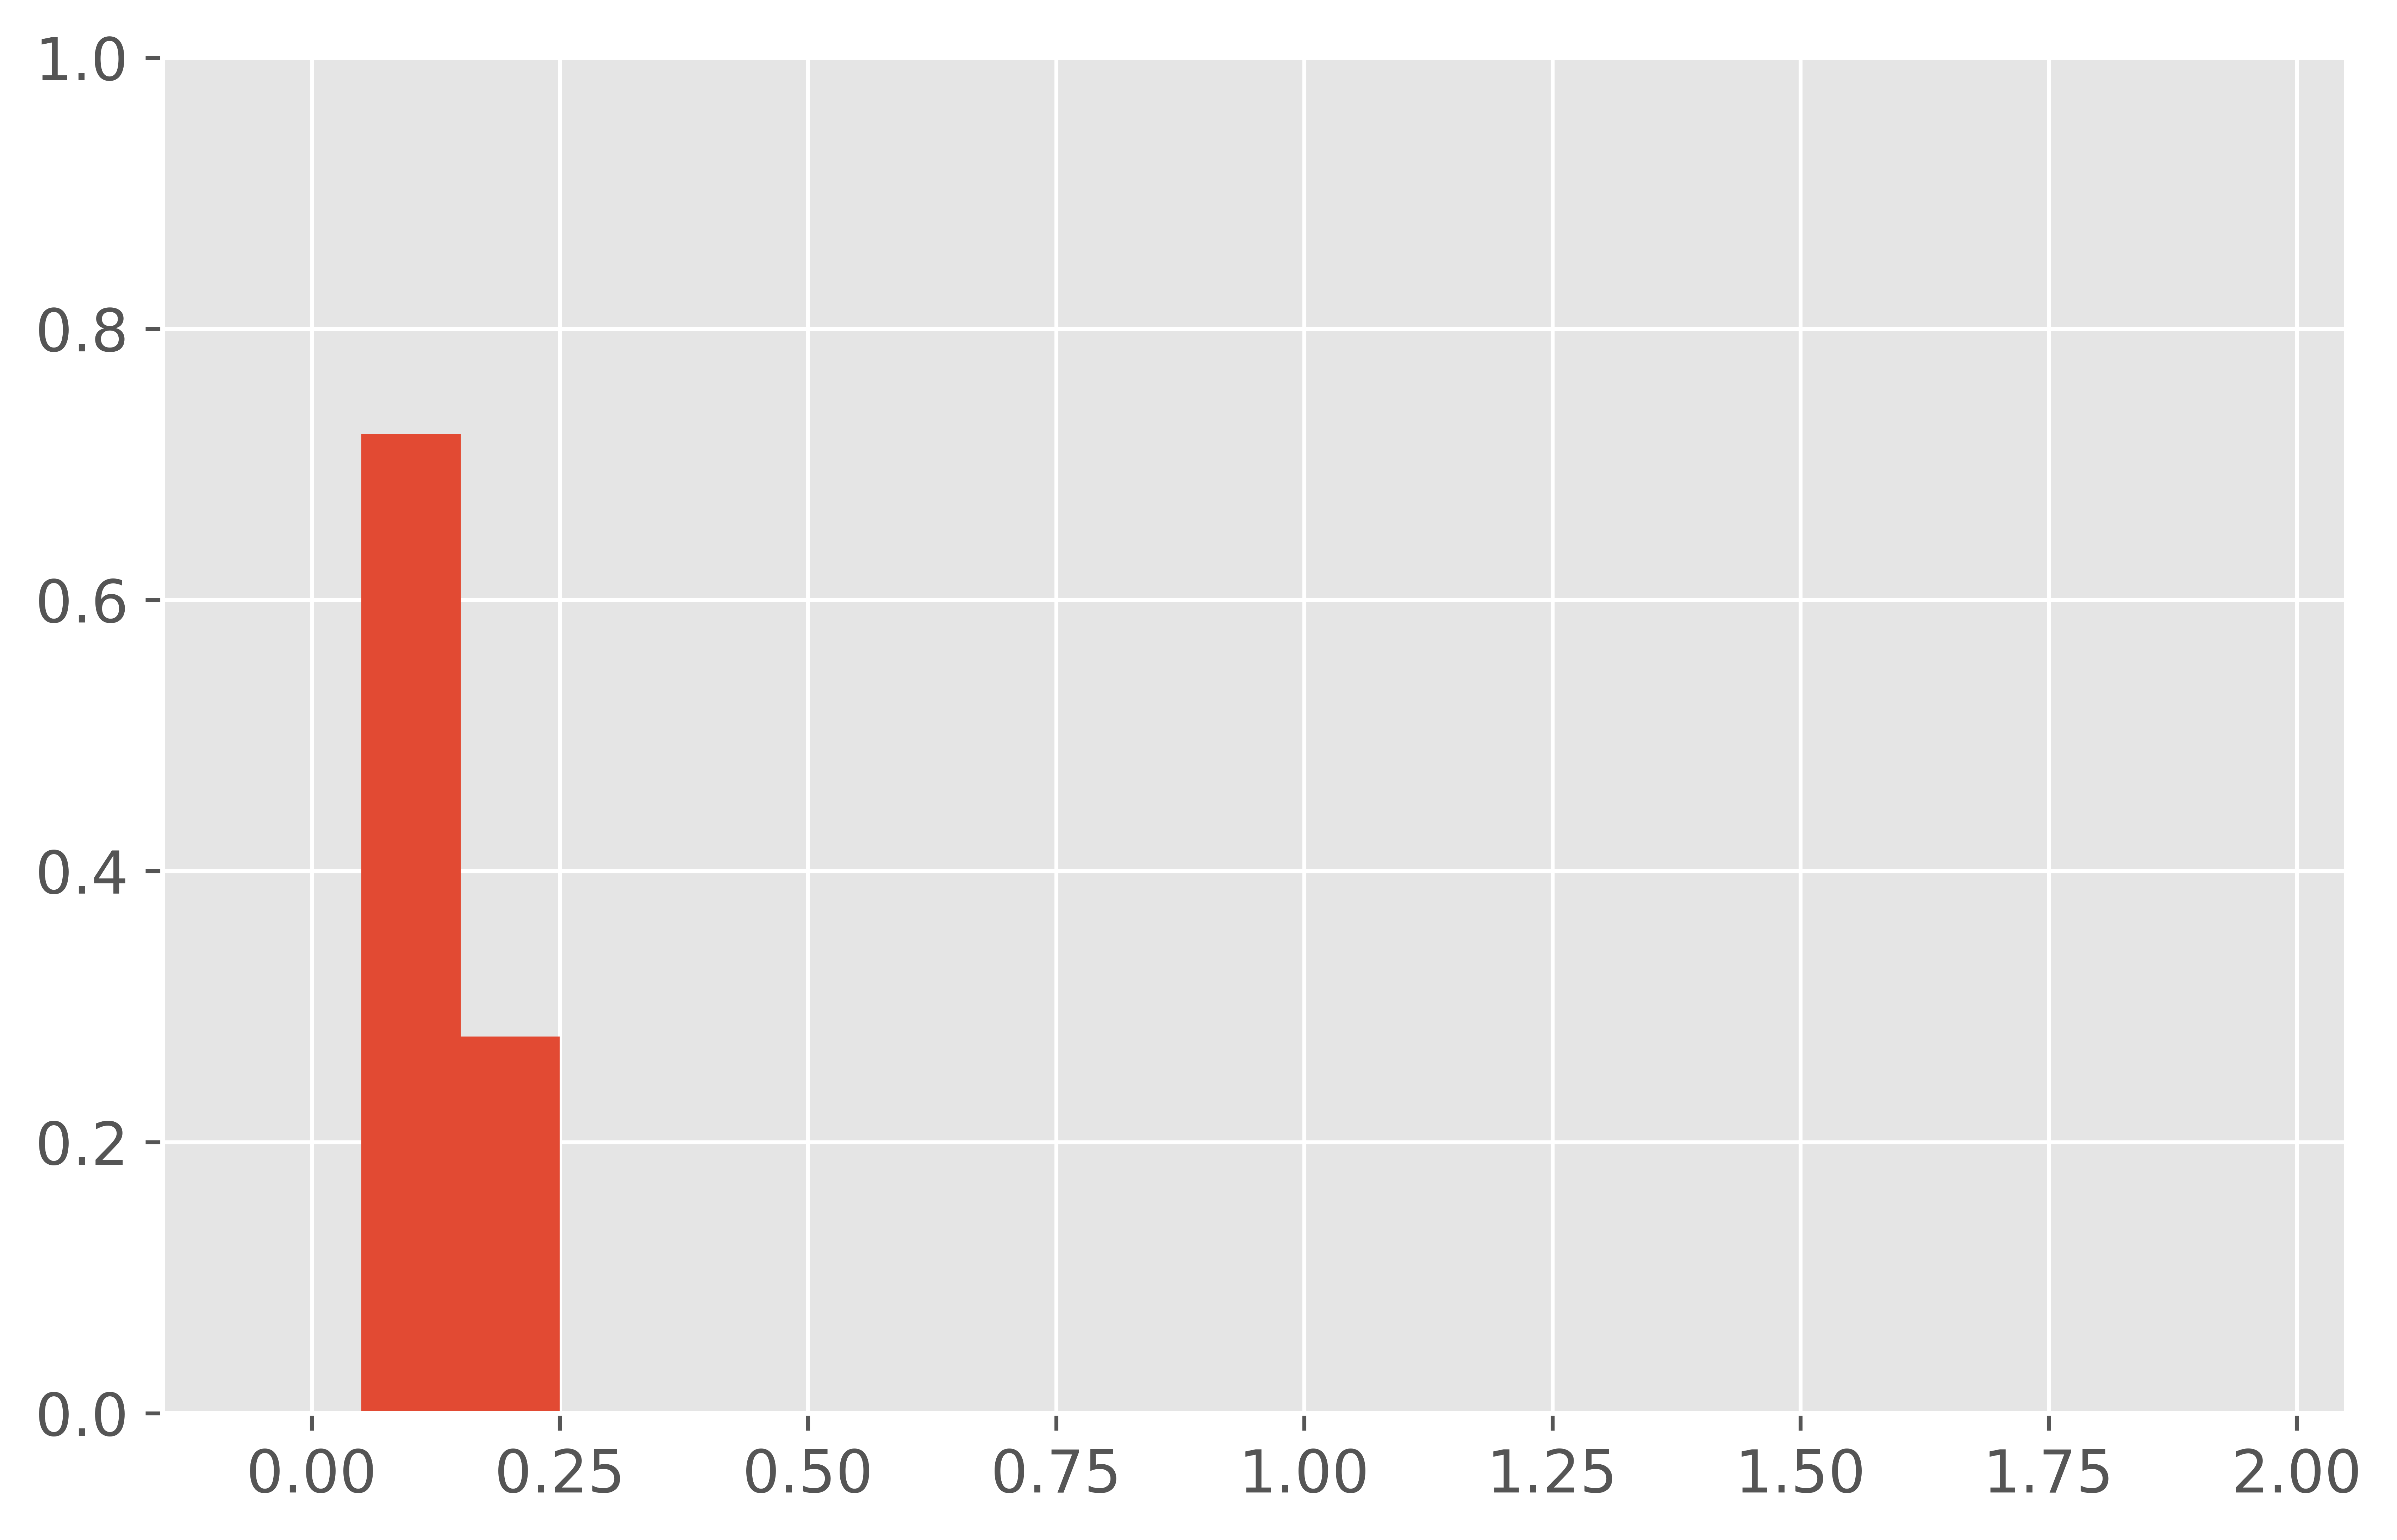

In [633]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
counts, edges = np.histogram(all_games_relative_variance_pairs, bins=20, range=(0,2))
x = edges[:-1]
widths = edges[1:] - edges[:-1]
area = counts * widths
density = area / np.sum(area)
ax.set_ylim(0, 1)
ax.bar(x, density, widths)
plt.savefig(f"results/difference_variance_evaluation/{game_type}({game.name})_aggregate_all_pairs", bbox_inches='tight')

In [634]:
mean_relative_variance_pais = np.mean(relative_variance_pairs, axis=1)

In [635]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
# counts, edges = np.histogram(mean_relative_variance_pais, bins=20, range=(0,2))
# x = edges[:-1]
# widths = edges[1:] - edges[:-1]
# area = counts * widths
# density = area / np.sum(area)
# ax.set_ylim(0, 1)
# ax.bar(x, density, widths)
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game.name})_mean_all_pairs", bbox_inches='tight')

In [636]:
k=1

In [637]:
sorted = np.argsort(-shapley_values, axis=1)
topk, rest = sorted[:, :k], sorted[:, k:]
topk.shape, rest.shape


((1, 1), (1, 8))

In [638]:
relative_variance[0]

array([[0.00, 0.23, 0.13, 0.16, 0.24, 0.14, 0.13, 0.14, 0.13],
       [0.23, 0.00, 0.23, 0.16, 0.30, 0.16, 0.23, 0.25, 0.23],
       [0.13, 0.23, 0.00, 0.16, 0.24, 0.14, 0.13, 0.14, 0.13],
       [0.16, 0.16, 0.16, 0.00, 0.17, 0.13, 0.16, 0.17, 0.16],
       [0.24, 0.30, 0.24, 0.17, 0.00, 0.18, 0.24, 0.19, 0.24],
       [0.14, 0.16, 0.14, 0.13, 0.18, 0.00, 0.14, 0.17, 0.14],
       [0.13, 0.23, 0.13, 0.16, 0.24, 0.14, 0.00, 0.14, 0.13],
       [0.14, 0.25, 0.14, 0.17, 0.19, 0.17, 0.14, 0.00, 0.14],
       [0.13, 0.23, 0.13, 0.16, 0.24, 0.14, 0.13, 0.14, 0.00]])

In [639]:
topk[0], rest[0]

(array([1], dtype=int64), array([3, 5, 8, 2, 0, 6, 4, 7], dtype=int64))

In [640]:
indices_topk = np.zeros((num_games, k, n-k), dtype=np.int32)
indices_rest = np.zeros((num_games, k, n-k), dtype=np.int32)
print(indices_topk.shape, indices_rest.shape)
for game in range(num_games):
    indices_topk[game], indices_rest[game] = np.meshgrid(topk[game], rest[game], indexing='ij')

(1, 1, 8) (1, 1, 8)


In [641]:
np.mgrid[:num_games, :k*(n-k)][0].shape

(1, 8)

In [642]:
relevant_pairs = relative_variance[np.mgrid[:num_games, :k*(n-k)][0], indices_topk.reshape(num_games, -1), indices_rest.reshape(num_games, -1)]
relevant_pairs

array([[0.16, 0.16, 0.23, 0.23, 0.23, 0.23, 0.30, 0.25]])

In [643]:
# histograms = []
# sub_x = 5
# sub_y = int(np.ceil(num_games/sub_x))
# fig, ax = plt.subplots(sub_y, sub_x, figsize=(6*sub_x,5*sub_y), dpi=100)
# for index, var in enumerate(relevant_pairs):
#     counts, edges = np.histogram(var, bins=20, range=(0,2))
#     x = edges[:-1]
#     widths = edges[1:] - edges[:-1]
#     area = counts * widths
#     density = area / np.sum(area)
#     i, j = index // sub_x, index % sub_x
#     ax[i,j].set_ylim(0, 1)
#     ax[i, j].bar(x, density, widths)
# fig.show()
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_all_games_top{k}_rest", bbox_inches='tight')

In [644]:
mean_relevant_pairs = np.mean(relevant_pairs, axis=1)

In [645]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
# counts, edges = np.histogram(mean_relevant_pairs, bins=20, range=(0,2))
# x = edges[:-1]
# widths = edges[1:] - edges[:-1]
# area = counts * widths
# density = area / np.sum(area)
# ax.set_ylim(0, 1)
# ax.bar(x, density, widths)
# plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_mean_top{k}_rest", bbox_inches='tight')

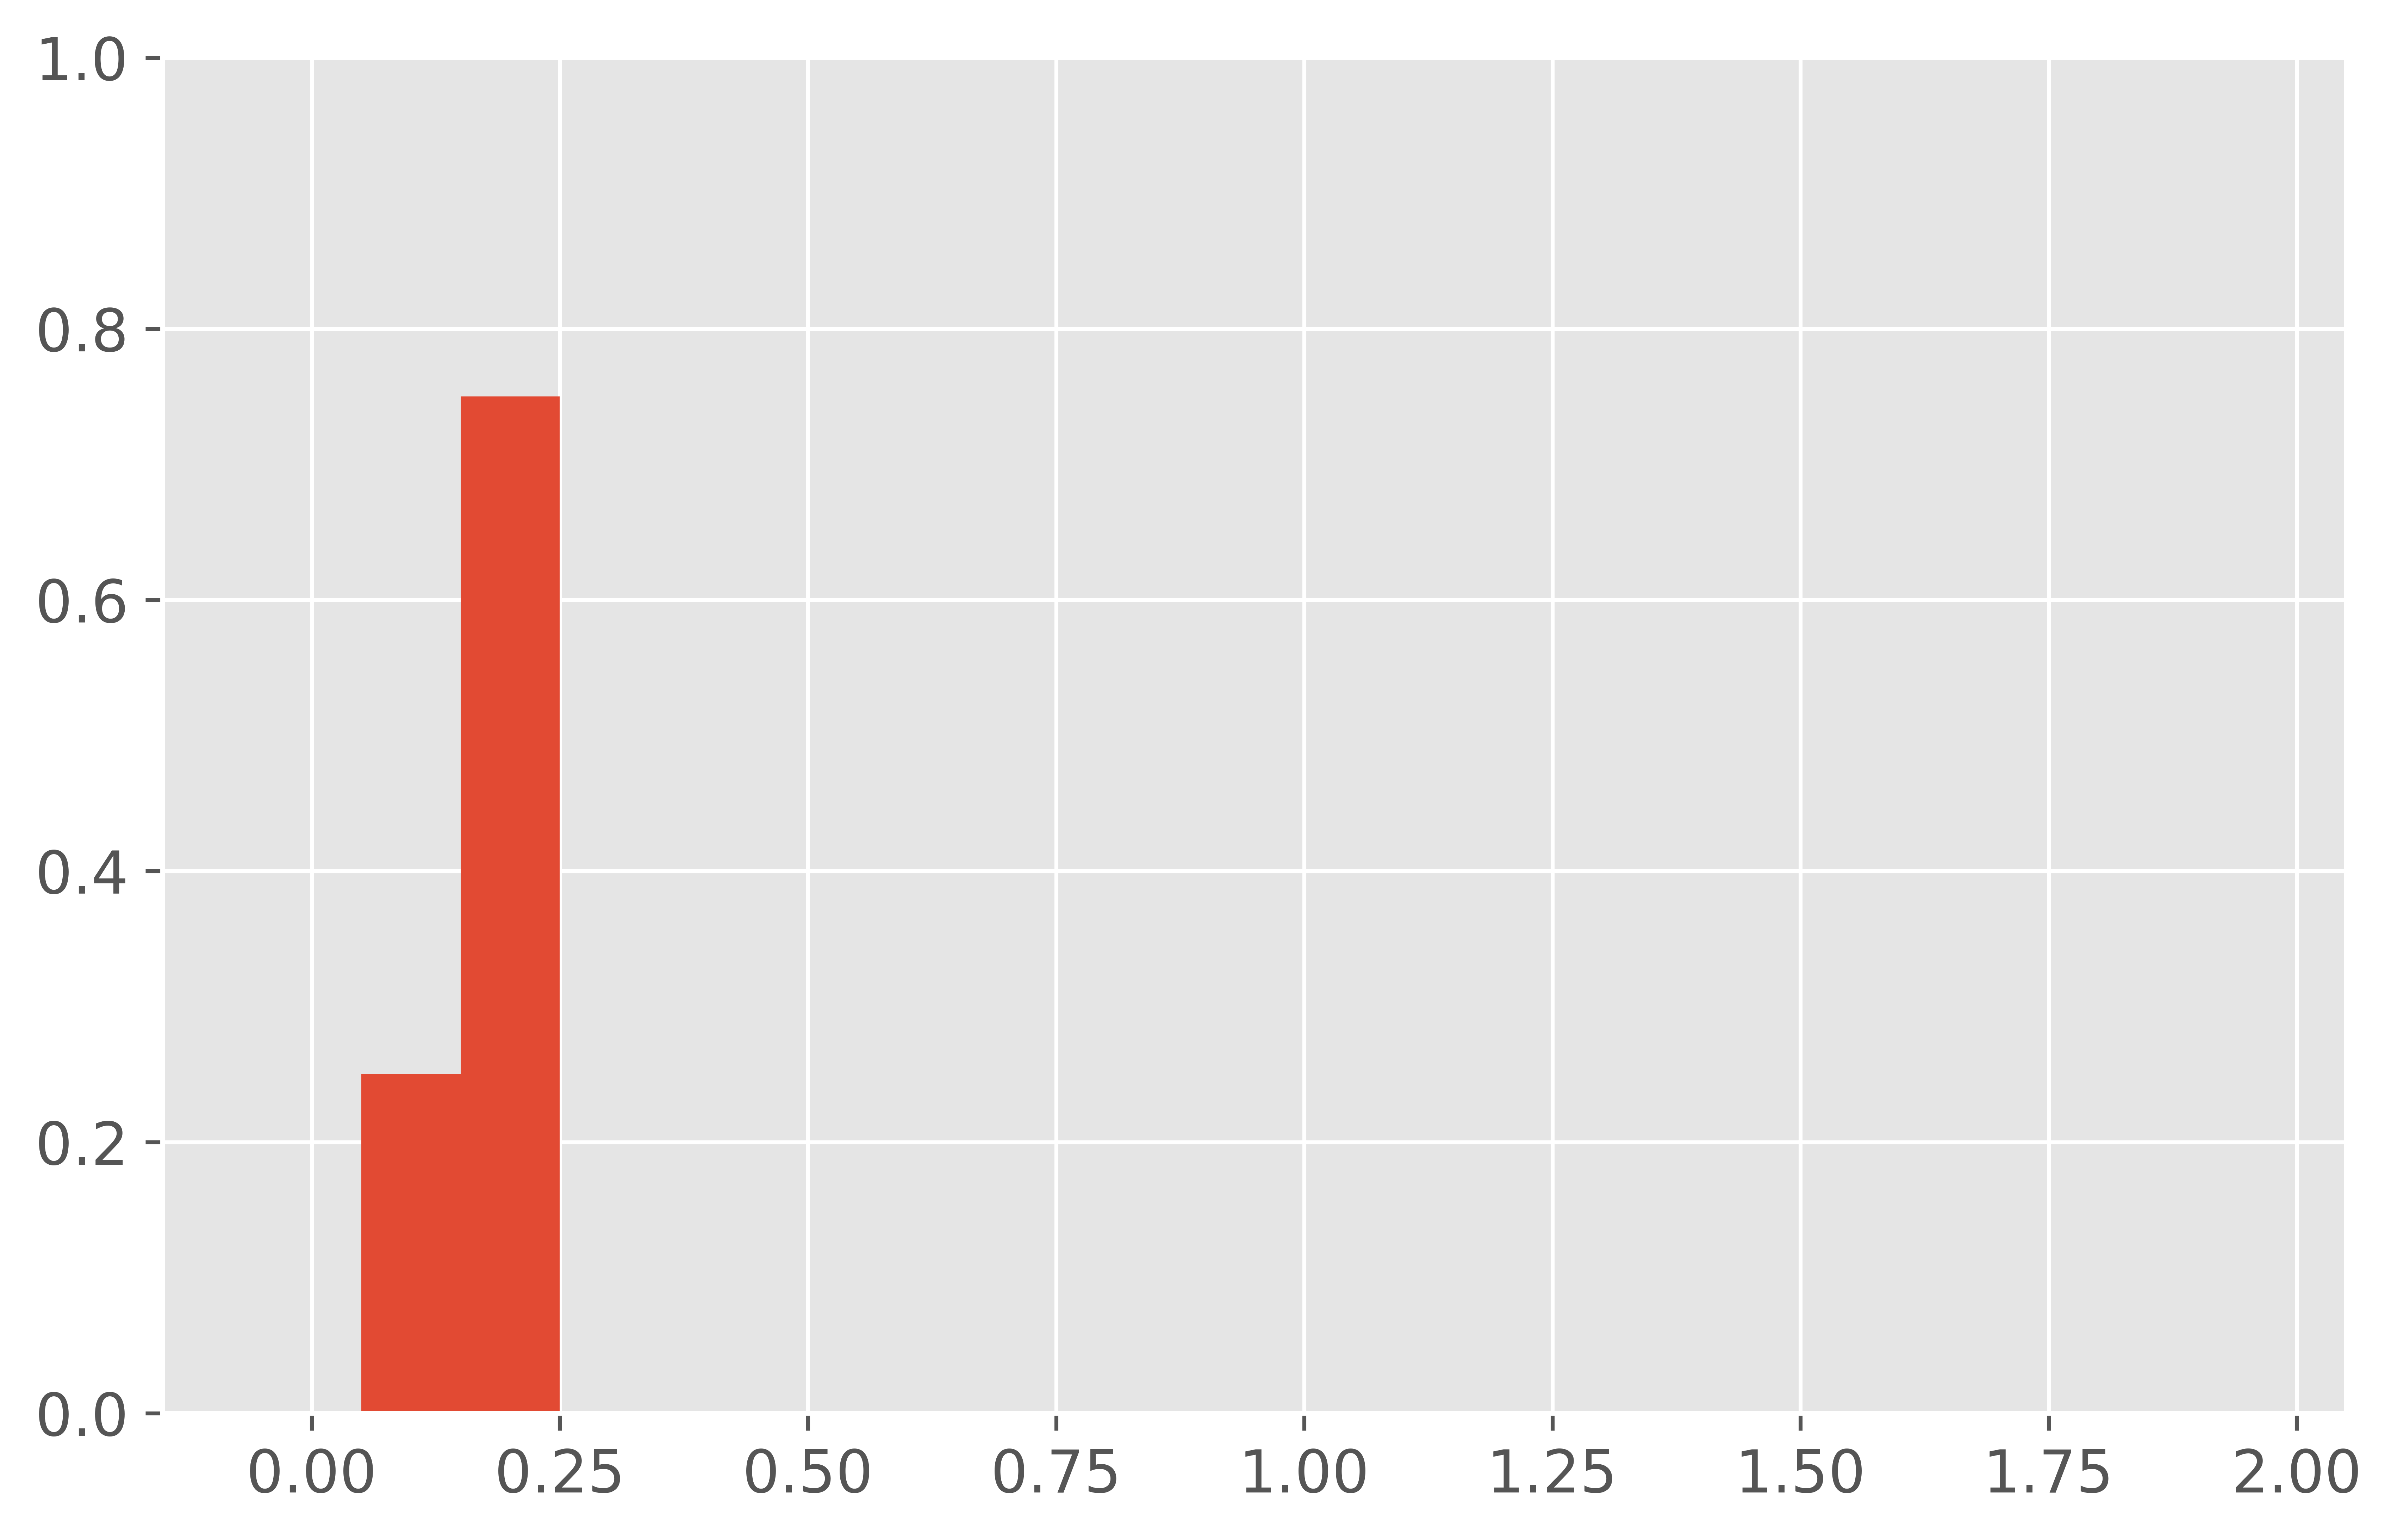

In [646]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
counts, edges = np.histogram(relevant_pairs.reshape(-1), bins=20, range=(0,2))
x = edges[:-1]
widths = edges[1:] - edges[:-1]
area = counts * widths
density = area / np.sum(area)
ax.set_ylim(0, 1)
ax.bar(x, density, widths)
plt.savefig(f"results/difference_variance_evaluation/{game_type}({game_name})_aggregate_top{k}_rest", bbox_inches='tight')